In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
from statsmodels.tsa.stattools import adfuller, q_stat
from scipy.stats import probplot, moment
from scipy import stats
matplotlib.rcParams['figure.figsize'] = (15, 10)

## Read Data

In [2]:
file_name1 = "price_execution_data_list"
file_name2 = "trade_book_data"

In [3]:
try:
    os.chdir("../DataBase/files")
except FileNotFoundError:
    pass
!ls -a

.
..
.DS_Store
Archive
price_execution_data_list_16-08-2022-13-24-21.json
price_execution_data_list_16-08-2022-15-32-04.json
trade_book_data_16-08-2022-13-24-21.json
trade_book_data_16-08-2022-15-32-04.json


In [4]:
def read_data_files(name_like: str):
    data_dict = {}
    for file_name in os.listdir():
        if name_like in file_name:
            data_dict[file_name] = pd.read_json(file_name)
    return data_dict

def aggregate_dict_to_dataframe(dictinary):
    df = pd.DataFrame()
    for key, val in dictinary.items():
        df = pd.concat([df, dictinary[key]], axis = 0)
    df.set_index("time", inplace=True)
    return df

In [5]:
price_execution_data = read_data_files(file_name1)
price_execution_data_df = aggregate_dict_to_dataframe(price_execution_data)

trade_book_data = read_data_files(file_name2)
trade_book_data_df = aggregate_dict_to_dataframe(trade_book_data)

del price_execution_data, trade_book_data

# will just use the first 10000 observations for EDA
price_execution_data_df = price_execution_data_df.sort_index().iloc[:10000]
trade_book_data_df = trade_book_data_df.sort_index().iloc[:10000]

## Time Sampling EDA

#### Excution Price

count    10000.000000
mean         0.764488
std          0.316026
min          0.532878
1%           0.546276
10%          0.610908
25%          0.612962
50%          0.614099
75%          0.691501
90%          1.330431
99%          2.046909
max          2.348767
Name: delta_time, dtype: float64


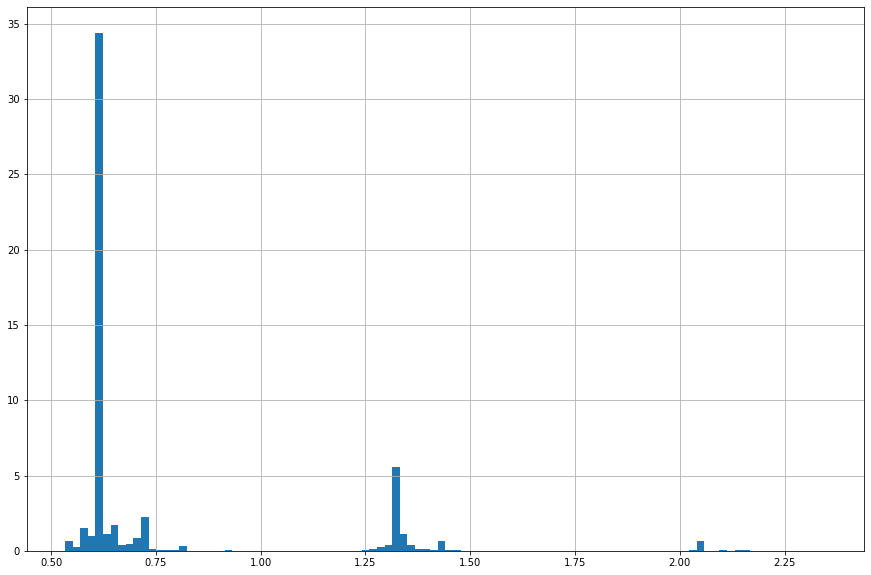

In [6]:
price_execution_data_df.delta_time.hist(bins = 100, density=True)
print(price_execution_data_df.delta_time.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]))

#### Trade Book Data

count    10000.000000
mean         0.764489
std          0.316026
min          0.532879
1%           0.546277
10%          0.610909
25%          0.612963
50%          0.614100
75%          0.691502
90%          1.330432
99%          2.046910
max          2.348768
Name: delta_time, dtype: float64


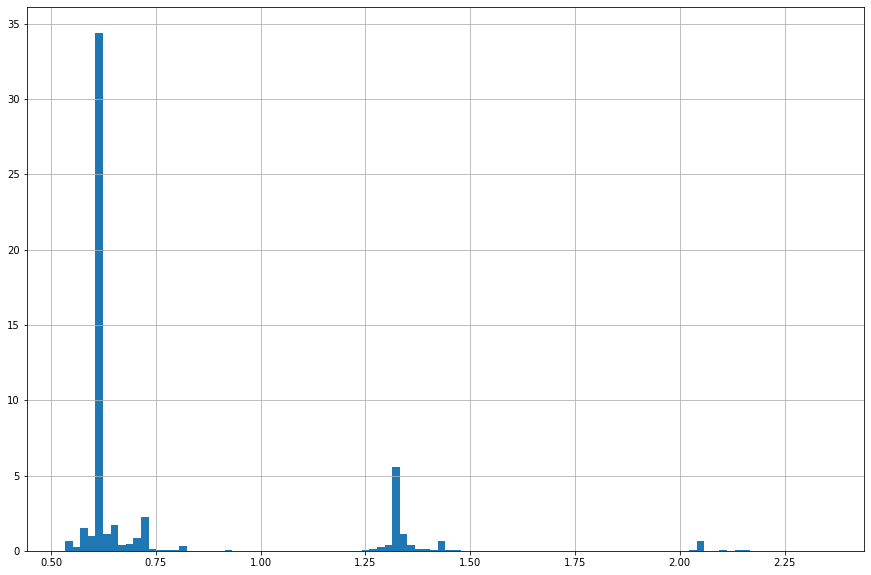

In [150]:
trade_book_data_df.delta_time.hist(bins = 100, density=True)
print(trade_book_data_df.delta_time.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]))

As illustrated above we have 3 modal distributions, where majority of density comes to distriubtion with the smallest time lag

#### Test
Question: Do we have signficant diffirence in time between REST requests?
<br />
H0: diff = 0
<br />
H1: diff != 0
<br />
Note difference is in seconds

In [143]:
stats.ttest_ind(trade_book_data_df.delta_time - price_execution_data_df.delta_time,
                [0 for i in range(trade_book_data_df.delta_time.shape[0])])

Ttest_indResult(statistic=199.01924181343819, pvalue=0.0)

According to t test, we reject Null Hypothesis, thus the difference in between time requests does not equal to zero.
<br />
From bellow histogram and summary statistics majority density indeed skewed to the right from 0, as well as not contatining negative teritory, which means

count    2.000000e+04
mean     1.148498e-06
std      8.161128e-07
min      0.000000e+00
1%       0.000000e+00
10%      7.152557e-07
25%      9.536743e-07
50%      9.536743e-07
75%      1.192093e-06
90%      1.907349e-06
99%      2.145767e-06
max      2.884865e-05
Name: delta_time, dtype: float64


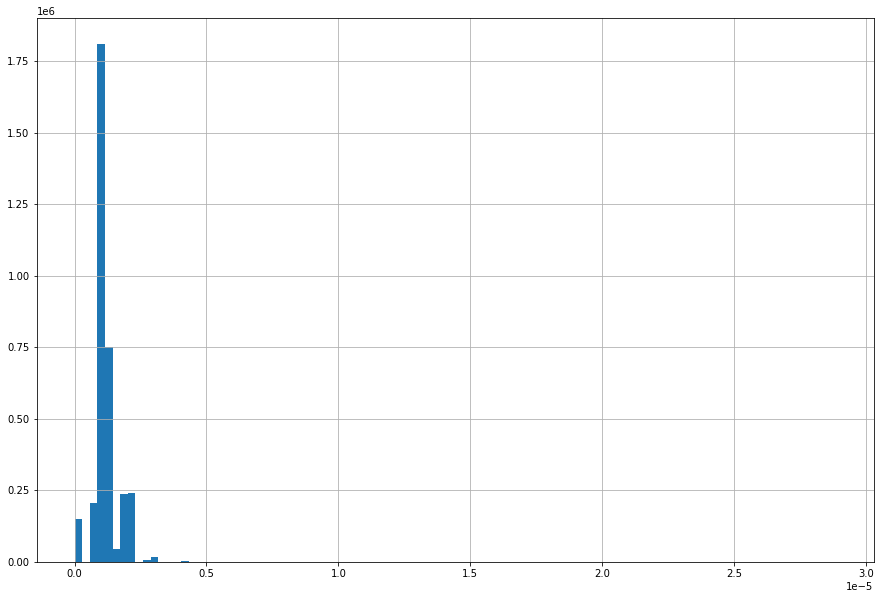

In [144]:
(trade_book_data_df.delta_time - price_execution_data_df.delta_time).hist(bins=100, density=True)
print((trade_book_data_df.delta_time - price_execution_data_df.delta_time).describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]))

In the best case scenario for futher analysis, one should develop better data fetching approach in order to reduce latency

## Time Series EDA

### Excution Price

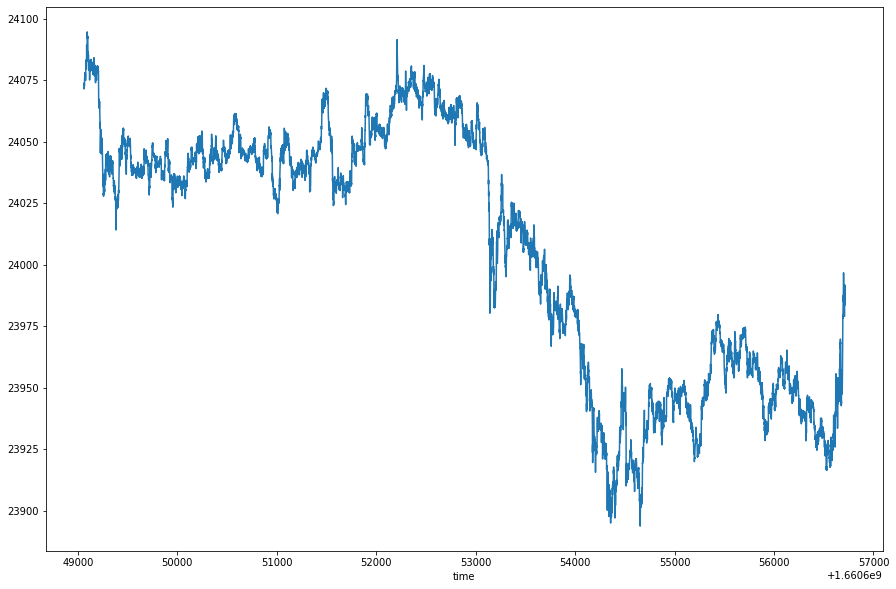

In [151]:
price_execution_data_df.price.plot()

The goal is to forecast the order price for both sides in the next 10 seconds, given that data has stochastic time sample period, we will try to figure out what would be the best rolling window size, which approximetely equals to 10 second period, using educated brute force method

In [146]:
def rolling_size(df, rolling_window):
    return df.delta_time.rolling(rolling_window).sum()

df_rolling_window = pd.DataFrame()
for rolling_window in range(6, 15):
    rolling_series = rolling_size(price_execution_data_df, rolling_window).dropna()
    df_rolling_window = pd.concat([df_rolling_window, pd.DataFrame({"sum_delta_time_in_seconds": rolling_series,
                                                                    "rolling_window": [rolling_window for _ in rolling_series]})], axis =0)

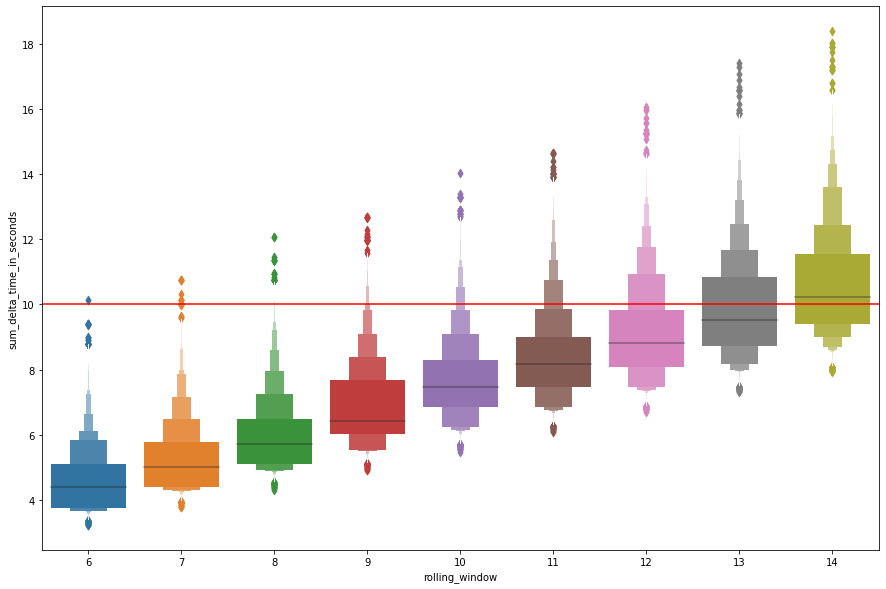

In [147]:
sns.boxenplot(x='rolling_window', y='sum_delta_time_in_seconds', data = df_rolling_window)
plt.axhline(y=10, color='r', linestyle='-')

In [261]:
df_rolling_window[df_rolling_window.rolling_window==13].sum_delta_time_in_seconds.describe()

count    19988.000000
mean         9.878102
std          1.489658
min          7.319819
25%          8.730092
50%          9.511876
75%         10.842873
max         17.396812
Name: sum_delta_time_in_seconds, dtype: float64

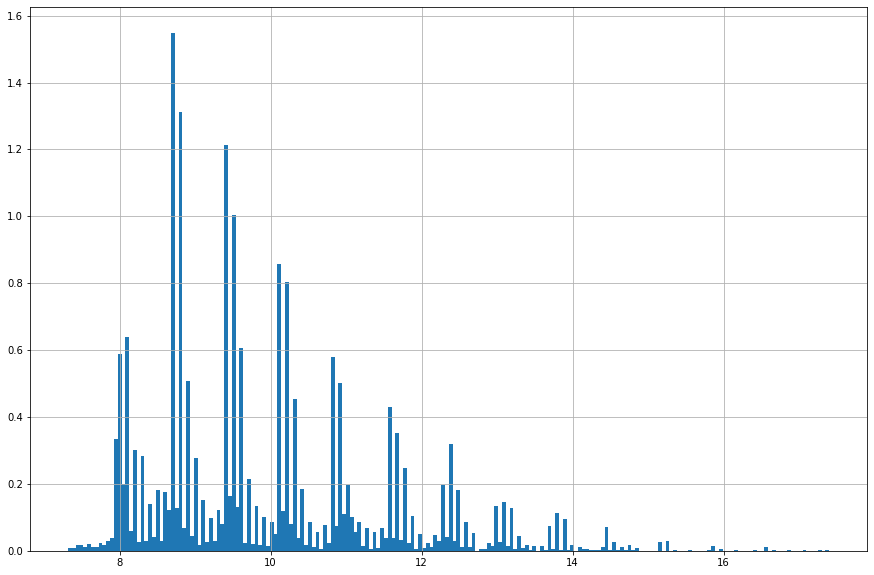

In [13]:
df_rolling_window[df_rolling_window.rolling_window==13].sum_delta_time_in_seconds.hist(bins=200, density=True)

#### Check Time Series (Returns) for specific rolling period for Stationarity

H0: time series has unit roots
<br />
H1: time series does not have unit roots
<br />
we will use thershold of .05, if p-value is not less than .05, we fail to reject the null hypothesis

In [ ]:
# Simulation Example with AR(1) with unit root and without
noise = np.random.normal(0,1,1000)
y1_statioanry = [1]
y2_not_stationary = [1]
for e in noise:
    y1_statioanry.append(y1_statioanry[-1]*0.5 + e) # param |x| < 1
    y2_not_stationary.append(y2_not_stationary[-1]*1 + e) # param |x| >= 1
y1_test = adfuller(y1_statioanry)
y2_test = adfuller(y2_not_stationary)
plt.plot(y1_statioanry, label=f"stationary test_val: {y1_test[0]}, p_val: {y1_test[1]}")
plt.plot(y2_not_stationary, label=f"not stationary test_val: {y2_test[0]}, p_val: {y2_test[1]}")
plt.title("Example of Stationary and not Stationary time series")
plt.legend()

In [13]:
data = price_execution_data_df.price
adf_stats, p_val, *args = adfuller(data.iloc[:999],maxlag=1 )
print("adf_stats:", adf_stats)
print("p_val:", p_val)

adf_stats: -1.844340896543953
p_val: 0.35868030295547576


In [14]:
price_execution_data_df.price.pct_change().dropna().iloc[:100]

time
1.660649e+09   -0.000013
1.660649e+09    0.000044
1.660649e+09    0.000057
1.660649e+09   -0.000057
1.660649e+09    0.000043
                  ...   
1.660649e+09   -0.000040
1.660649e+09    0.000017
1.660649e+09    0.000011
1.660649e+09    0.000005
1.660649e+09    0.000026
Name: price, Length: 100, dtype: float64

In [15]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(14).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1], dist="norm")
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

/Users/efim/opt/anaconda3/envs/SimpleAlgoTrading/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


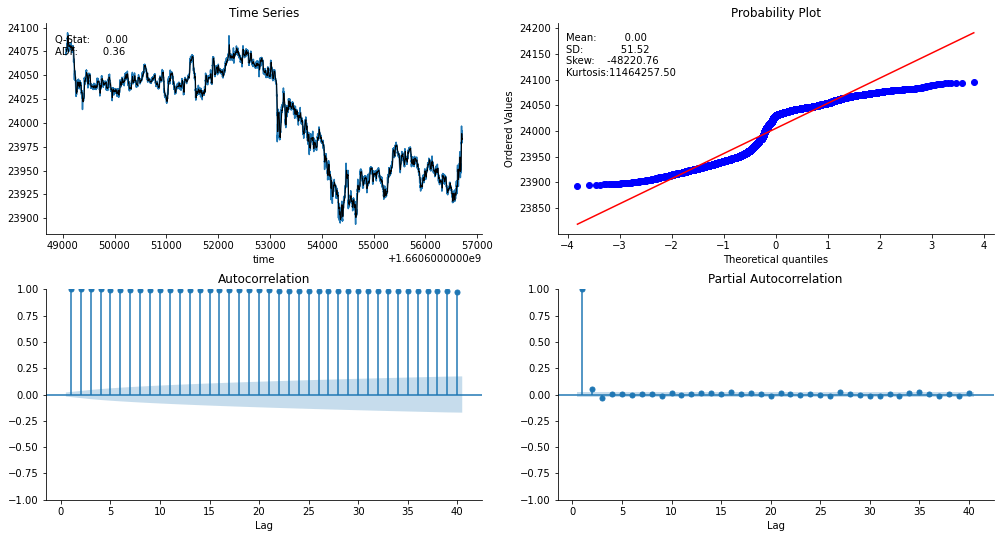

In [16]:
plot_correlogram(price_execution_data_df.price, lags = 40)

/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


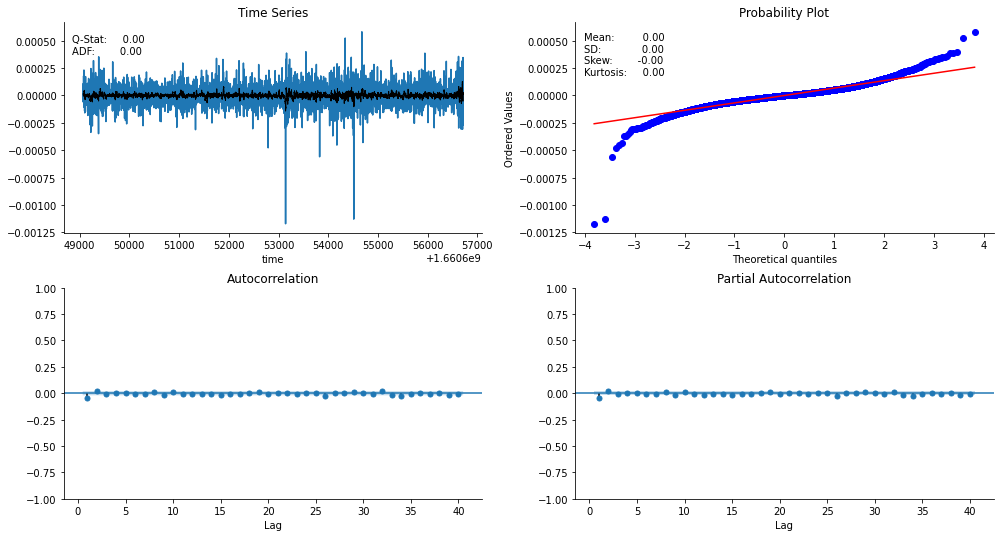

In [102]:
# Since returns are 1st order Diffierence, the expected result might be stationary
returns = price_execution_data_df.price.pct_change().dropna()
plot_correlogram(returns, lags = 40)

The goal is to use time window for model training, thus it might be helpfull to see whether there exists certain time window where the series is stationary

In [166]:
#Note Heavy calculation
#One can run on returns instead by adding .pct_change().dropna() or removing it to run on prices
returns = price_execution_data_df.price.pct_change().dropna()

dictionary_adfuller = {}
for rolling_window in [10, 25 ,50, 75, 100, 250]:
    start = 0
    end = rolling_window
    adf_stats_list = []
    adf_pval_list = []
    while end < returns.shape[0]:
        data = returns.iloc[start:end]
        adf_stats, p_val, *args = adfuller(data)
        adf_stats_list.append(adf_stats)
        adf_pval_list.append(p_val)
        start+=1 
        end+=1
    dictionary_adfuller[rolling_window] = {"adf_stats":adf_stats_list,"adf_pval": adf_pval_list}

In [167]:
df_adf_test_stats=pd.DataFrame()
for key, val in dictionary_adfuller.items():
    df_adf_test_stats = pd.concat([df_adf_test_stats, pd.DataFrame({"adf_stats": val["adf_stats"],
                                                                    "adf_pval": val["adf_pval"],
                                                                    "rolling_window_size": [key for _ in val["adf_stats"]]})])

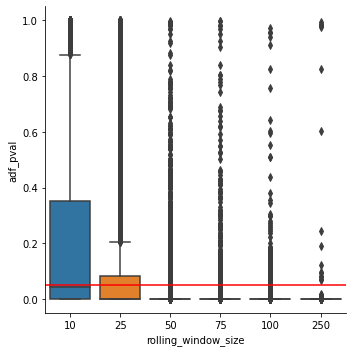

In [168]:
sns.catplot(x='rolling_window_size', y='adf_pval', data = df_adf_test_stats, kind= "box")
plt.axhline(y=0.05, color='r', linestyle='-')

For rolling window > 25, our P_val is close to zero which means, we reject null hypothesis, which means series are stationary on average. For rolling window <= 25, only some samples seems to stationary.
</br>
If the pvalue is above a critical size, then we cannot reject that there is a unit root

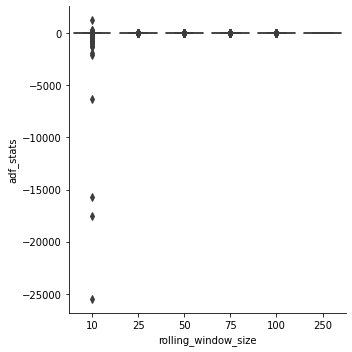

In [169]:
sns.catplot(x='rolling_window_size', y='adf_stats', data = df_adf_test_stats, kind= "box")
# would not be able to plot threshold of adf_stats since it depends on sample size

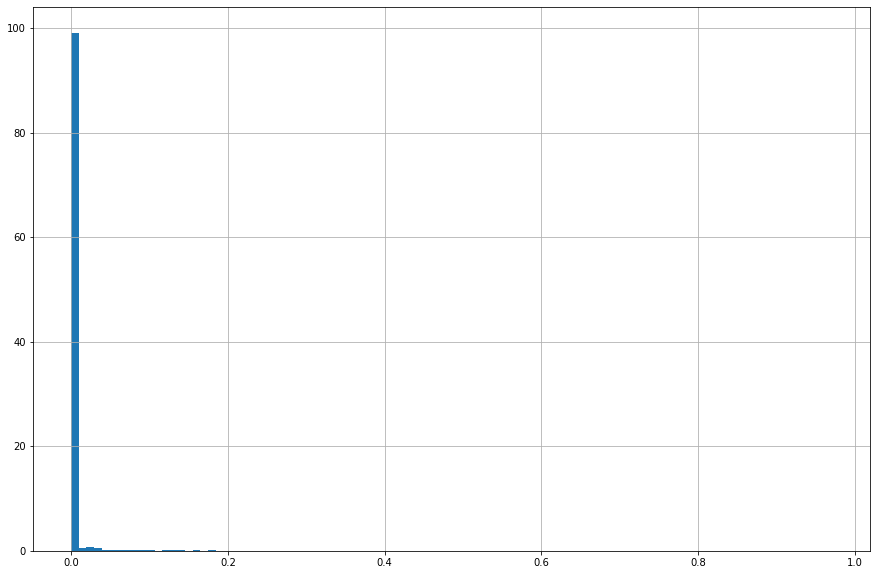

In [170]:
df_adf_test_stats[df_adf_test_stats.rolling_window_size == 100].adf_pval.hist(bins =100, density=True)

In [171]:
(df_adf_test_stats[df_adf_test_stats.rolling_window_size == 100].adf_pval < 0.05).value_counts()

True     9725
False     174
Name: adf_pval, dtype: int64

### Trade Book

In [208]:
trade_book_data_df.head(10)

,lastUpdateId,bids,asks,delta_time,best_bid,best_ask,bid_ask_spread,wavg_bid,wavg_ask
time,,,,,,,,,
1.660649e+09,22582626043,"[[24070.72000000, 0.00999000], [24070.63000000...","[[24071.35000000, 0.04163000], [24071.39000000...",1.332420,24070.72,24071.35,0.63,24067.585228,24074.717677
1.660649e+09,22582626554,"[[24071.80000000, 0.07643000], [24071.79000000...","[[24072.20000000, 0.00049000], [24073.01000000...",0.611655,24071.80,24072.20,0.40,24068.572755,24075.983169
1.660649e+09,22582627376,"[[24071.86000000, 0.00250000], [24071.81000000...","[[24073.26000000, 0.02282000], [24073.27000000...",1.330176,24071.86,24073.26,1.40,24067.997296,24076.703290
1.660649e+09,22582628007,"[[24071.52000000, 0.02596000], [24071.32000000...","[[24072.11000000, 0.00791000], [24072.58000000...",0.592219,24071.52,24072.11,0.59,24067.995685,24076.394277
1.660649e+09,22582628370,"[[24072.41000000, 0.00050000], [24072.36000000...","[[24072.75000000, 0.04313000], [24072.78000000...",0.634878,24072.41,24072.75,0.34,24068.703929,24075.737878
1.660649e+09,22582628798,"[[24073.19000000, 0.03702000], [24073.17000000...","[[24073.52000000, 0.00044000], [24073.71000000...",0.613496,24073.19,24073.52,0.33,24069.425480,24076.581634
1.660649e+09,22582629235,"[[24073.91000000, 0.00982000], [24073.46000000...","[[24074.46000000, 0.01694000], [24074.66000000...",0.613734,24073.91,24074.46,0.55,24069.556875,24077.698569
1.660649e+09,22582629857,"[[24075.95000000, 0.00001000], [24075.94000000...","[[24076.99000000, 0.02850000], [24077.00000000...",0.612184,24075.95,24076.99,1.04,24071.138546,24081.125727
1.660649e+09,22582630379,"[[24076.40000000, 0.02182000], [24076.37000000...","[[24077.28000000, 0.00042000], [24077.29000000...",0.717076,24076.40,24077.28,0.88,24074.122173,24081.471036


In [205]:
trade_book_data_df["best_bid"] = trade_book_data_df.bids.apply(lambda x: x[0][0]).astype(float)
trade_book_data_df["best_ask"] = trade_book_data_df.asks.apply(lambda x: x[0][0]).astype(float)
trade_book_data_df["bid_ask_spread"] = trade_book_data_df["best_ask"] - trade_book_data_df["best_bid"]

def calc_waverage_price(x):
    """
    Note it is not VWAP,
    it is weight average over 100 quotes
    """
    prices = np.array(x)[:,0].astype(float)
    volumes = np.array(x)[:,1].astype(float)
    return np.dot(prices,volumes)/np.sum(volumes)

trade_book_data_df["wavg_bid"] = trade_book_data_df.bids.apply(lambda x: calc_waverage_price(x))
trade_book_data_df["wavg_ask"] = trade_book_data_df.asks.apply(lambda x: calc_waverage_price(x))

#### Bid-Ask-Spread Analysis

count    10000.000000
mean         0.819031
std          0.467078
min          0.010000
25%          0.490000
50%          0.800000
75%          1.100000
max          3.930000
Name: bid_ask_spread, dtype: float64


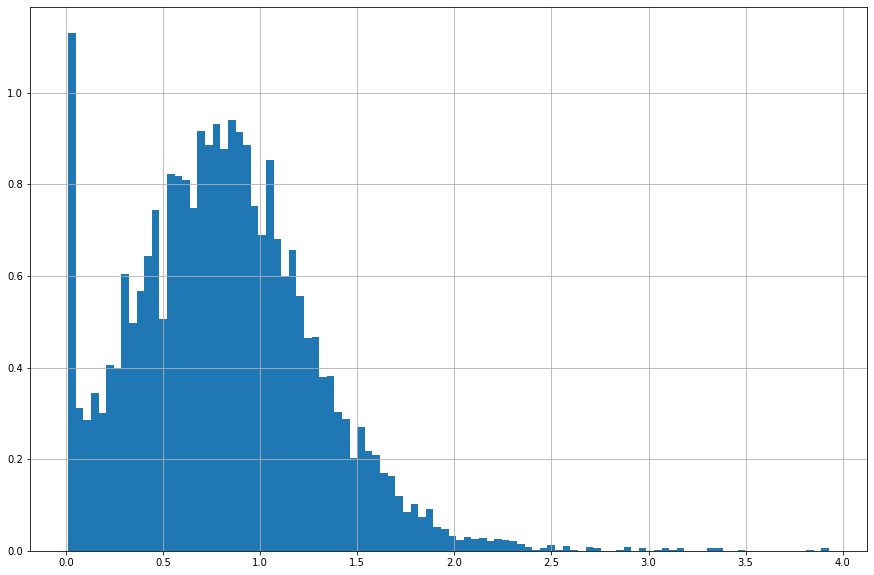

In [210]:
print(trade_book_data_df["bid_ask_spread"].describe())
trade_book_data_df["bid_ask_spread"].hist(bins=100, density=True)

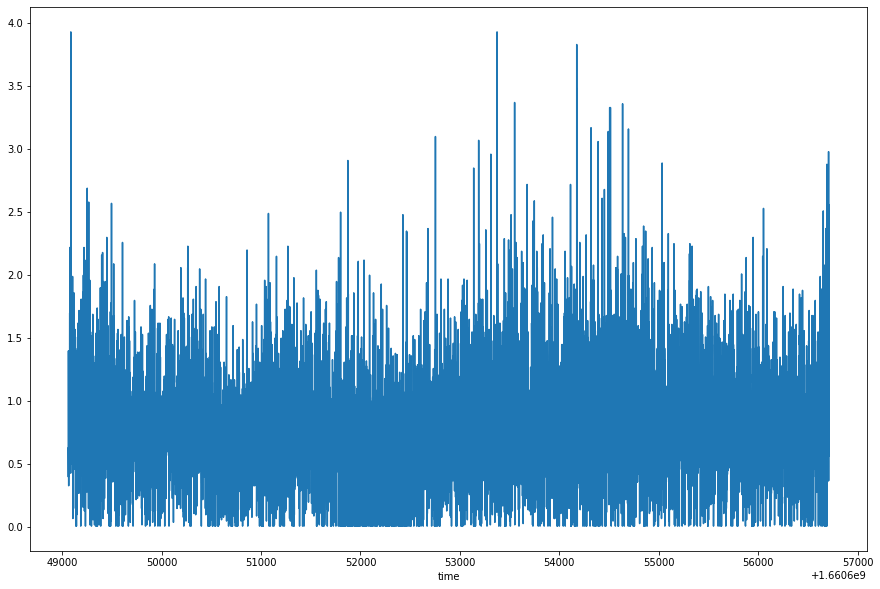

In [219]:
trade_book_data_df["bid_ask_spread"].plot()

How many price executions are not within the range of best bid and best ask due to data fetching latency?

In [225]:
df_ = trade_book_data_df[["best_bid", "best_ask"]].merge(price_execution_data_df["price"], left_index= True, right_index=True)

In [238]:
ratio = 100*df_[~((df_["price"] >= df_["best_bid"]) & (df_["price"] <= df_["best_ask"]))].shape[0]/df_.shape[0]
print(f"the best exuction price is not within the bid ask range {ratio}%")

the best exuction price is not within the bid ask range 60.29%


#### Expiriment with another REST Request

In [240]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/Users/efim/PycharmProjects/")
sys.path.append("/Users/efim/PycharmProjects/SimpleAlgoTrade/")
from SimpleAlgoTrade.DataFetch.FetchRealTimeData import FetchRealTimeData

symbol = "BTCUSDT"
URL = FetchRealTimeData.API_URL + f"/api/v3/aggTrades?symbol={symbol}"

obj = FetchRealTimeData()
data = obj.get_data(URL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
data[0]

{'a': 1403985266,
 'p': '23882.43000000',
 'q': '0.01445000',
 'f': 1641110437,
 'l': 1641110437,
 'T': 1660673054629,
 'm': False,
 'M': True}

In [243]:
timestamps = [x["T"] for x in data]

count    499.000000
mean      24.705411
std       57.031868
min        0.000000
25%        0.000000
50%        4.000000
75%       18.000000
max      466.000000
dtype: float64


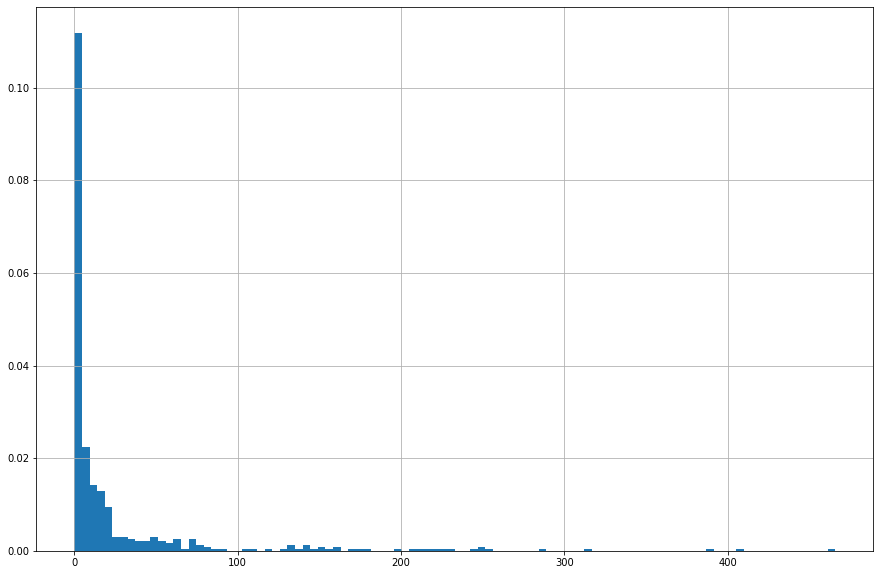

In [259]:
delta_time = pd.Series(timestamps) - pd.Series(timestamps).shift(1).dropna()
print(delta_time.describe())
delta_time.hist(bins=100, density=True)